# ImageFolderDataset Guide: Working with NEON Beetle Images

This notebook demonstrates how to use the `ImageFolderDataset` class from the HPC Inference package with the [2018 NEON Beetles dataset](https://huggingface.co/datasets/imageomics/2018-NEON-beetles). 

The ImageFolderDataset is designed for efficient streaming of large image collections, with support for:
- **Distributed processing** across multiple workers/ranks
- **Multiple preprocessing pipelines** for different models
- **Flexible UUID generation** from file paths
- **Image validation** using PIL
- **Memory-efficient streaming** for large datasets

## Dataset Overview

The 2018 NEON Beetles dataset contains:
- 577 high-resolution group images of ethanol-preserved beetles
- Beetles collected from NEON ecological sites in 2018
- Multiple beetles per image, organized by species
- Rich metadata including species labels, site information, and measurements

We'll work with the `group_images` folder which contains the original full-size images.

## Setup and Installation

First, let's install the required packages and download the dataset.

In [1]:
# Install required packages (if not already installed)
# Note: If you're using this in a new environment, uncomment the following line:
# !pip install hpc_inference datasets huggingface_hub torch torchvision open_clip_torch pillow matplotlib

# Import required libraries
import os
import torch
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np

## Download the NEON Beetles Dataset

We'll download the dataset using the Hugging Face datasets library.

In [4]:
from datasets import load_dataset
from huggingface_hub import snapshot_download

# Download the full dataset (this might take a while - ~5GB)
# We'll focus on the group_images folder
data_dir = "./neon_beetles_data"

# Download the dataset
snapshot_download(
    repo_id="imageomics/2018-NEON-beetles",
    repo_type="dataset",
    local_dir=data_dir,
    allow_patterns=["group_images/*"]  # Only download group images
)

# Set up paths
image_dir = Path(data_dir) / "group_images"
print(f"Dataset downloaded to: {image_dir}")
print(f"Number of images: {len(list(image_dir.glob('*.jpg')))}")

/fs/scratch/PAS2136/netzissou/venv/cardinal_inference/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 578 files: 100%|██████████| 578/578 [00:00<00:00, 635.80it/s]


Dataset downloaded to: neon_beetles_data/group_images
Number of images: 577


## Import ImageFolderDataset

Now let's import the ImageFolderDataset from our HPC inference package.

In [ ]:
# Import the ImageFolderDataset from the installed package
from hpc_inference.datasets.image_folder_dataset import ImageFolderDataset

# Import the collate functions from distributed utils
from hpc_inference.utils.distributed import pil_image_collate

## Basic Usage

Let's start with the simplest usage - loading images without any preprocessing.

**Important Note**: When using `preprocess=None` (returning PIL Images), we need a custom collate function because PyTorch's default collate function only knows how to handle tensors, numpy arrays, numbers, dicts, and lists - not PIL Image objects.

In [10]:
# Create a basic dataset (no preprocessing)
basic_dataset = ImageFolderDataset(
    image_dir=image_dir,
    preprocess=None,  # No preprocessing - returns PIL Images
    uuid_mode="filename"  # Use filename as UUID
)

print(f"Dataset contains {len(basic_dataset)} images")

# Create a DataLoader with custom collate function for PIL Images
# Note: We need a custom collate function because PyTorch's default collate 
# function doesn't know how to handle PIL Image objects
basic_loader = DataLoader(
    basic_dataset, 
    batch_size=2, 
    num_workers=1,
    collate_fn=pil_image_collate  # Use our custom collate function
)

# Get first batch
for uuids, images in basic_loader:
    print(f"Batch UUIDs: {uuids}")
    print(f"Image types: {[type(img) for img in images]}")
    print(f"Image sizes: {[img.size for img in images]}")
    break

2025-07-11 15:22:24,047 - INFO - Rank 0 assigned 577 out of 577 images


Dataset contains 577 images


2025-07-11 15:22:24,072 - INFO - [Rank 0/Worker 0] Processing 577 images


Batch UUIDs: ['A00000001831.jpg', 'A00000003356.jpg']
Image types: [<class 'PIL.Image.Image'>, <class 'PIL.Image.Image'>]
Image sizes: [(5568, 3712), (5568, 3712)]


## Image Validation

When working with large datasets from unknown sources, you might want to validate that all images can be properly loaded.

In [ ]:
# Create dataset with validation enabled
# Note: This will be slower as it validates each image
validated_dataset = ImageFolderDataset(
    image_dir=image_dir,
    preprocess=None,
    validate=True,  # Enable validation
    uuid_mode="filename"
)

print(f"Validated dataset contains {len(validated_dataset)} valid images")

# Compare with non-validated count
total_jpg_files = len(list(image_dir.glob('*.jpg')))
print(f"Total .jpg files in directory: {total_jpg_files}")
print(f"Valid images after validation: {len(validated_dataset)}")

if len(validated_dataset) < total_jpg_files:
    print(f"{total_jpg_files - len(validated_dataset)} images failed validation")
else:
    print("All images passed validation")

2025-07-11 15:33:15,081 - INFO - Rank 0 assigned 577 out of 577 images


Validated dataset contains 577 valid images
Total .jpg files in directory: 577
Valid images after validation: 577
All images passed validation


## Single Model Preprocessing

Now let's add preprocessing for a single computer vision model. We'll use a simple ResNet preprocessing pipeline.

In [12]:
# Define preprocessing for a single model (e.g., ResNet)
resnet_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset with single model preprocessing
single_model_dataset = ImageFolderDataset(
    image_dir=image_dir,
    preprocess=resnet_transform,
    uuid_mode="filename",
    validate=True  # Set to True for safer operation with unknown image quality
)

# Create DataLoader
single_loader = DataLoader(single_model_dataset, batch_size=4, num_workers=1)

# Get a batch and examine the output
for uuids, tensor_batch in single_loader:
    print(f"Batch UUIDs: {uuids}")
    print(f"Tensor batch shape: {tensor_batch.shape}")
    print(f"Tensor dtype: {tensor_batch.dtype}")
    print(f"Tensor range: [{tensor_batch.min():.3f}, {tensor_batch.max():.3f}]")
    break

2025-07-11 15:22:50,871 - INFO - Rank 0 assigned 577 out of 577 images
2025-07-11 15:22:50,891 - INFO - [Rank 0/Worker 0] Processing 577 images


Batch UUIDs: ('A00000001831.jpg', 'A00000003356.jpg', 'A00000008914.jpg', 'A00000008915.jpg')
Tensor batch shape: torch.Size([4, 3, 224, 224])
Tensor dtype: torch.float32
Tensor range: [-1.998, 2.588]


## Multi-Model Preprocessing

Another feature of ImageFolderDataset is support for multiple model preprocessing pipelines simultaneously. This is useful when you want to generate embeddings for the same images using different models.

In [13]:
# Define preprocessing for multiple models

import open_clip
    
# Get CLIP preprocessing functions
_, _, clip_preprocess_vit_b = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
_, _, clip_preprocess_vit_l = open_clip.create_model_and_transforms('ViT-L-14', pretrained='openai')

# Create multi-model preprocessing dictionary
multi_model_preprocess = {
    "clip_vit_b32": clip_preprocess_vit_b,
    "clip_vit_l14": clip_preprocess_vit_l,
    "resnet": resnet_transform
}

# Create dataset with multi-model preprocessing
multi_model_dataset = ImageFolderDataset(
    image_dir=image_dir,
    preprocess=multi_model_preprocess,
    uuid_mode="relative",  # Use relative path as UUID
    validate=False
)

print(f"Multi-model dataset created with {len(multi_model_preprocess)} preprocessing pipelines")

2025-07-11 15:23:28,363 - INFO - Loaded ViT-B-32 model config.
2025-07-11 15:23:29,171 - INFO - Loading pretrained ViT-B-32 weights (openai).
2025-07-11 15:23:29,296 - INFO - Loaded ViT-L-14 model config.
2025-07-11 15:23:31,198 - INFO - Loading pretrained ViT-L-14 weights (openai).
2025-07-11 15:23:31,327 - INFO - Rank 0 assigned 577 out of 577 images


Multi-model dataset created with 3 preprocessing pipelines


For multi-model datasets, we need to use a special collate function

In [15]:
from hpc_inference.utils.distributed import multi_model_collate

# Create DataLoader with multi-model collate function
multi_loader = DataLoader(
    multi_model_dataset, 
    batch_size=2, 
    num_workers=1,  
    collate_fn=multi_model_collate
)

# Get a batch and examine the output
for uuids, data_dict in multi_loader:
    print(f"Batch UUIDs: {uuids}")
    print(f"Available models: {list(data_dict.keys())}")
    
    for model_name, tensor in data_dict.items():
        print(f"  {model_name}: shape {tensor.shape}, dtype {tensor.dtype}")
    break

2025-07-11 15:24:23,760 - INFO - [Rank 0/Worker 0] Processing 577 images


Batch UUIDs: ['A00000001831.jpg', 'A00000003356.jpg']
Available models: ['clip_vit_b32', 'clip_vit_l14', 'resnet']
  clip_vit_b32: shape torch.Size([2, 3, 224, 224]), dtype torch.float32
  clip_vit_l14: shape torch.Size([2, 3, 224, 224]), dtype torch.float32
  resnet: shape torch.Size([2, 3, 224, 224]), dtype torch.float32


## UUID Generation Modes

The ImageFolderDataset supports different ways to generate unique identifiers from file paths.

In [16]:
# Test different UUID modes
uuid_modes = ["filename", "relative", "fullpath", "hash"]

for mode in uuid_modes:
    print(f"\n--- UUID Mode: {mode} ---")
    
    dataset = ImageFolderDataset(
        image_dir=image_dir,
        preprocess=None,
        uuid_mode=mode
    )
    
    loader = DataLoader(
        dataset, 
        batch_size=2, 
        num_workers=1,
        collate_fn=pil_image_collate  # Use custom collate for PIL images
    )
    
    # Get first batch and show UUIDs
    for uuids, images in loader:
        for uuid in uuids:
            print(f"  UUID: {uuid}")
        break

2025-07-11 15:25:46,483 - INFO - Rank 0 assigned 577 out of 577 images



--- UUID Mode: filename ---


2025-07-11 15:25:46,505 - INFO - [Rank 0/Worker 0] Processing 577 images
2025-07-11 15:25:47,138 - INFO - Rank 0 assigned 577 out of 577 images


  UUID: A00000001831.jpg
  UUID: A00000003356.jpg

--- UUID Mode: relative ---


2025-07-11 15:25:47,155 - INFO - [Rank 0/Worker 0] Processing 577 images
2025-07-11 15:25:47,722 - INFO - Rank 0 assigned 577 out of 577 images


  UUID: A00000001831.jpg
  UUID: A00000003356.jpg

--- UUID Mode: fullpath ---


2025-07-11 15:25:47,738 - INFO - [Rank 0/Worker 0] Processing 577 images
2025-07-11 15:25:48,367 - INFO - Rank 0 assigned 577 out of 577 images


  UUID: neon_beetles_data/group_images/A00000001831.jpg
  UUID: neon_beetles_data/group_images/A00000003356.jpg

--- UUID Mode: hash ---


2025-07-11 15:25:48,384 - INFO - [Rank 0/Worker 0] Processing 577 images


  UUID: 90c34117768767de
  UUID: 7c9f84fc44e0e5df


## Distributed Processing Simulation

The ImageFolderDataset is designed for distributed processing across multiple workers/ranks. Let's simulate this by creating multiple dataset instances with different rank settings.

In [17]:
# Simulate distributed processing with 3 workers
world_size = 3
rank_datasets = []

print(f"Distributing images across {world_size} workers:")

for rank in range(world_size):
    dataset = ImageFolderDataset(
        image_dir=image_dir,
        preprocess=None,
        rank=rank,
        world_size=world_size,
        evenly_distribute=True,  # Distribute based on file sizes
        uuid_mode="filename"
    )
    
    rank_datasets.append(dataset)
    print(f"  Rank {rank}: {len(dataset)} images")

# Verify no overlap between ranks
all_files = set()
for rank, dataset in enumerate(rank_datasets):
    rank_files = set(dataset.image_files)
    overlap = all_files.intersection(rank_files)
    if overlap:
        print(f"WARNING: Rank {rank} has overlapping files: {overlap}")
    all_files.update(rank_files)

print(f"\nTotal unique files across all ranks: {len(all_files)}")
print(f"Original total files: {len(list(image_dir.glob('*.jpg')))}")

# Example: Create a DataLoader for one of the rank datasets
if rank_datasets:
    example_loader = DataLoader(
        rank_datasets[0], 
        batch_size=2, 
        num_workers=0,
        collate_fn=pil_image_collate  # Use custom collate for PIL images
    )
    print(f"\nExample from Rank 0:")
    for uuids, images in example_loader:
        print(f"  First batch UUIDs: {uuids}")
        break

2025-07-11 15:27:01,756 - INFO - Rank 0 assigned 193 files (total size: 0.98 GB)
2025-07-11 15:27:01,757 - INFO - Rank 0 assigned 193 out of 577 images
2025-07-11 15:27:01,759 - INFO - Rank 1 assigned 192 files (total size: 0.98 GB)
2025-07-11 15:27:01,759 - INFO - Rank 1 assigned 192 out of 577 images
2025-07-11 15:27:01,761 - INFO - Rank 2 assigned 192 files (total size: 0.98 GB)
2025-07-11 15:27:01,761 - INFO - Rank 2 assigned 192 out of 577 images
2025-07-11 15:27:01,763 - INFO - [Rank 0/Worker 0] Processing 193 images


Distributing images across 3 workers:
  Rank 0: 193 images
  Rank 1: 192 images
  Rank 2: 192 images

Total unique files across all ranks: 577
Original total files: 577

Example from Rank 0:
  First batch UUIDs: ['A00000051603.jpg', 'A00000051179.jpg']


## Visualizing Processed Images

Let's visualize some images and their processed versions to understand what the preprocessing is doing.

2025-07-11 15:34:04,113 - INFO - Rank 0 assigned 577 out of 577 images
2025-07-11 15:34:04,114 - INFO - Rank 0 assigned 577 out of 577 images
2025-07-11 15:34:04,179 - INFO - [Rank 0/Worker 0] Processing 577 images
2025-07-11 15:34:04,282 - INFO - [Rank 0/Worker 0] Processing 577 images


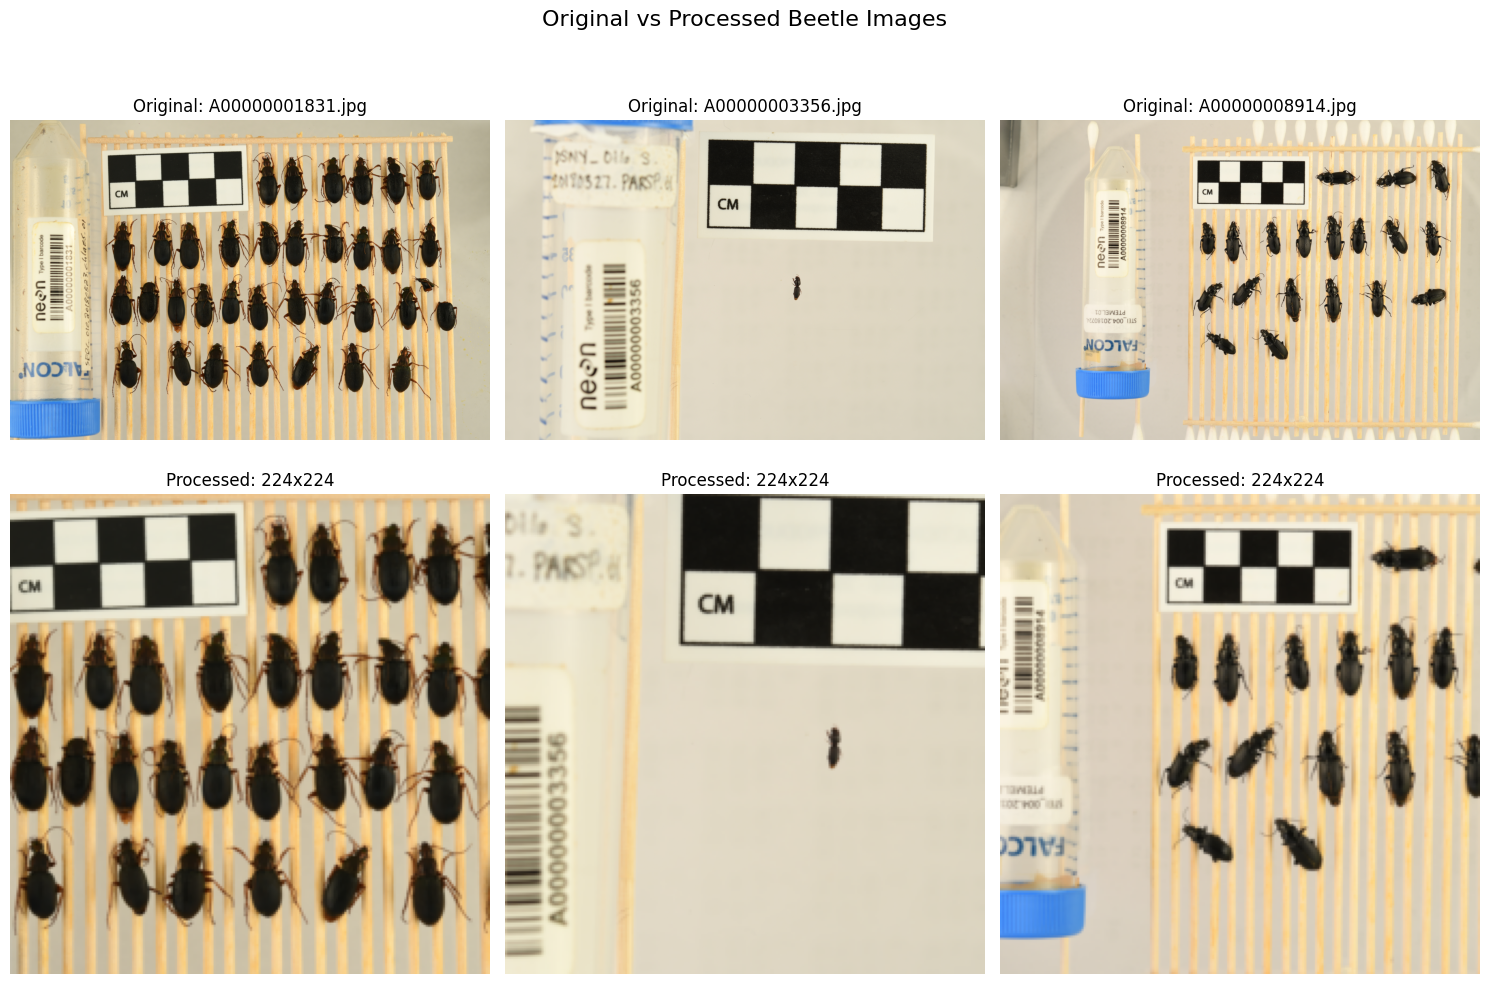

In [19]:
# Create datasets for visualization
raw_dataset = ImageFolderDataset(image_dir=image_dir, preprocess=None, uuid_mode="filename")
processed_dataset = ImageFolderDataset(image_dir=image_dir, preprocess=resnet_transform, uuid_mode="filename")

# Get loaders - note the different collate functions needed
raw_loader = DataLoader(
    raw_dataset, 
    batch_size=1, 
    num_workers=0,
    collate_fn=pil_image_collate  # Custom collate for PIL images
)
processed_loader = DataLoader(
    processed_dataset, 
    batch_size=1, 
    num_workers=0
    # Default collate works fine for tensors
)

# Function to denormalize tensor for visualization
def denormalize_tensor(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalize a tensor for visualization."""
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

# Visualize first few images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Original vs Processed Beetle Images', fontsize=16)

raw_iter = iter(raw_loader)
processed_iter = iter(processed_loader)

for i in range(3):
    # Get raw image
    uuid_raw, img_raw = next(raw_iter)
    uuid_proc, tensor_proc = next(processed_iter)
    
    # Display original
    axes[0, i].imshow(img_raw[0])
    axes[0, i].set_title(f'Original: {uuid_raw[0]}')
    axes[0, i].axis('off')
    
    # Display processed (denormalized)
    denorm_tensor = denormalize_tensor(tensor_proc[0])
    denorm_tensor = torch.clamp(denorm_tensor, 0, 1)
    img_processed = denorm_tensor.permute(1, 2, 0).numpy()
    
    axes[1, i].imshow(img_processed)
    axes[1, i].set_title(f'Processed: 224x224')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Performance Considerations

Let's explore some performance aspects of the ImageFolderDataset.

In [20]:
import time

# Test different configurations
configs = [
    {"name": "Single worker", "num_workers": 0, "batch_size": 8},
    {"name": "Multi worker", "num_workers": 2, "batch_size": 8},
    {"name": "Larger batch", "num_workers": 2, "batch_size": 16},
]

# Create a dataset for performance testing
perf_dataset = ImageFolderDataset(
    image_dir=image_dir,
    preprocess=resnet_transform,
    uuid_mode="filename",
    validate=False
)

print("Performance comparison (processing first 50 images):")
print("-" * 60)

for config in configs:
    loader = DataLoader(
        perf_dataset,
        batch_size=config["batch_size"],
        num_workers=config["num_workers"],
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    start_time = time.time()
    images_processed = 0
    
    for uuids, tensors in loader:
        images_processed += len(uuids)
        if images_processed >= 50:  # Stop after 50 images
            break
    
    elapsed = time.time() - start_time
    images_per_sec = images_processed / elapsed
    
    print(f"{config['name']:15} | {images_processed:3d} images | "
          f"{elapsed:5.2f}s | {images_per_sec:5.1f} img/s")

2025-07-11 15:35:18,793 - INFO - Rank 0 assigned 577 out of 577 images
2025-07-11 15:35:19,738 - INFO - [Rank 0/Worker 0] Processing 577 images


Performance comparison (processing first 50 images):
------------------------------------------------------------
Single worker   |  56 images | 14.47s |   3.9 img/s


2025-07-11 15:35:34,238 - INFO - [Rank 0/Worker 0] Processing 289 images
2025-07-11 15:35:34,238 - INFO - [Rank 0/Worker 1] Processing 288 images


Multi worker    |  56 images |  7.79s |   7.2 img/s


2025-07-11 15:35:42,006 - INFO - [Rank 0/Worker 0] Processing 289 images
2025-07-11 15:35:42,009 - INFO - [Rank 0/Worker 1] Processing 288 images


Larger batch    |  64 images |  8.65s |   7.4 img/s


## Best Practices and Tips

Based on our exploration, here are some key recommendations for using `ImageFolderDataset` effectively:

### 1. **Choose the Right UUID Mode**
- Use `"filename"` for simple cases where filenames are unique
- Use `"relative"` when you have subdirectories and need to preserve path structure
- Use `"hash"` for anonymization or when dealing with non-unique filenames across nested folders

### 2. **Validation**
- Enable `validate=True` when working with unknown image quality
- Disable it for trusted datasets to improve performance

### 3. **Multi-Model Processing**
- Use multi-model preprocessing when you need different input formats
- Remember to use the `multi_model_collate` function in your DataLoader

### 4. **Distributed Processing & Performance Optimization**
- Set `evenly_distribute=True` for better load balancing across workers
- Increase `num_workers` for I/O bound tasks
- Use larger batch sizes when memory allows
- Enable `pin_memory=True` when using GPU